# Aprendizaje Automático II - Trabajo Práctico N°1

- Antuña, Franco (A-4637/1)
- Asad, Gonzalo (A-4595/1)
- Castells, Sergio (C-7334/2)

----------------

# Preparación del Entorno

In [1]:
!pip install gdown

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import statsmodels.api as sm
import joblib



import gdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from PIL import Image
import os
import cv2
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling, Lambda
from keras.layers import GlobalAveragePooling2D, Add
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications.mobilenet import preprocess_input

Establecer GPU por defecto en caso de estar disponible.

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Problema 3

## Preparación del Dataset

In [4]:
# Definir el ID del archivo
file_id = '1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'

# Crear la URL de descarga
download_url = f'https://drive.google.com/uc?id={file_id}'

# Descargar el archivo
output = 'TP1-3-natural-scenes.zip'
gdown.download(download_url, output, quiet=True)

# Descomprimir el .zip
!unzip TP1-3-natural-scenes.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

## Análisis Exploratorio

Para evitar mensajes asociados a cambios planeados en futuras versiones de las librerías en uso, hacemos uso de la función 'filterwarnings'.

In [5]:
warnings.filterwarnings('ignore', category=FutureWarning)

Analizamos si el dataset se encuentra balanceado, para un correcto entrenamiento del modelo (sin sesgo fuerte).

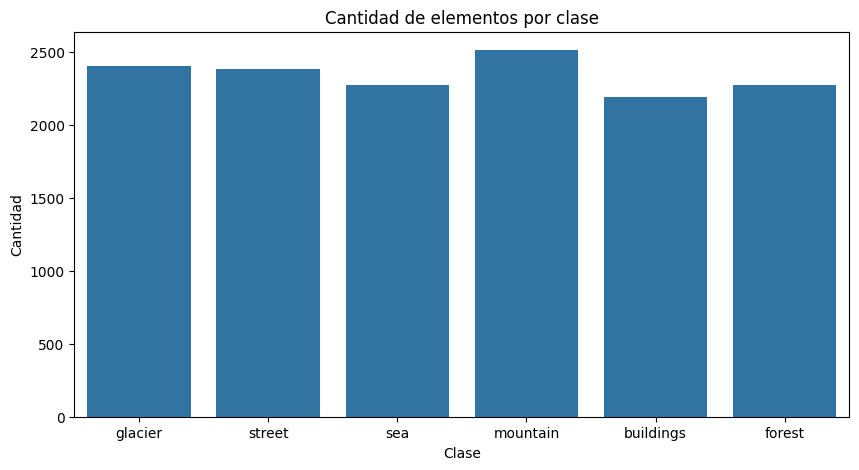


La clase con menos elementos es buildings con 2191 elementos.
La clase con más elementos es street con 2382 elementos.
La diferencia de elementos entre las clases mayoritaria y minoritaria es del 8.02%


In [6]:
def contar_elementos(ruta):
    """
    Cuenta el número de archivos y carpetas en una carpeta y sus subcarpetas.
    Args:
        ruta: La ruta de la carpeta.

    Returns:
        Un entero que representa el número total de elementos.
    """
    dict_content = {}

    for dirpath, dirnames, filenames in os.walk(ruta):
      for dir in dirnames:
          ruta_dir = ruta + "/" + dir
          dict_content[dir] = len(os.listdir(ruta_dir))
    return dict_content

ruta_de_la_carpeta = "/content/seg_train/seg_train"
numero_de_elementos = contar_elementos(ruta_de_la_carpeta)

plt.figure(figsize=(10,5))
sns.barplot(data = numero_de_elementos)
plt.title("Cantidad de elementos por clase")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

print("\nLa clase con menos elementos es", min(numero_de_elementos), "con", numero_de_elementos[min(numero_de_elementos)], "elementos.")
print("La clase con más elementos es", max(numero_de_elementos), "con", numero_de_elementos[max(numero_de_elementos)], "elementos.")
porc = 100 - numero_de_elementos[min(numero_de_elementos)]/numero_de_elementos[max(numero_de_elementos)]*100
print(f"La diferencia de elementos entre las clases mayoritaria y minoritaria es del {porc:.2f}%")

En vista de los datos anteriores, podemos considerar que el dataset se encuentra lo suficientemente bien balanceado. A continuación, evaluamos el tamaño de las imágenes.

In [7]:
def dimensiones_imagenes(ruta):
  try:
    with Image.open(ruta) as img:
      return img.size
  except IOError:
    return None

ruta_de_la_carpeta = "/content/seg_train/seg_train"
lista_dimensiones = []

for dirpath, dirnames, filenames in os.walk(ruta_de_la_carpeta):
  for filename in filenames:
    ruta = os.path.join(dirpath, filename)
    dimensiones = dimensiones_imagenes(ruta)
    if dimensiones:
      lista_dimensiones.append(dimensiones)
    else:
      print(f"No se pudo procesar {ruta}")

print("Las imágenes tienen alguna de las siguientes dimensiones:", list(set(lista_dimensiones)))

Las imágenes tienen alguna de las siguientes dimensiones: [(150, 136), (150, 81), (150, 145), (150, 142), (150, 105), (150, 102), (150, 108), (150, 111), (150, 120), (150, 123), (150, 135), (150, 141), (150, 144), (150, 150), (150, 147), (150, 110), (150, 113), (150, 119), (150, 131), (150, 76), (150, 134), (150, 140), (150, 143), (150, 146), (150, 149), (150, 100), (150, 97), (150, 103), (150, 115), (150, 124), (150, 133)]


No todas las imágenes tienen las mismas dimensiones, por lo que será necesario llevarlas a todas al mismo tamaño antes de procesarlas (sea achicándolas o completando con padding).

En vista que el dataset se compone de imágenes que varían desde mares hasta calles (donde los primeros tienen mucho color azul y los últimos mucho color gris), se asume que los modelos podrán aprovechar esta característica para sus predicciones. Por este motivo, preliminarmente, ensayaremos los modelos con las fotos en RGB.

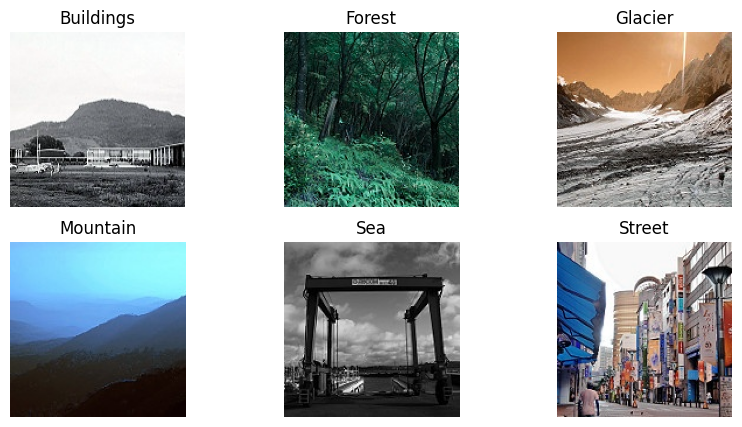

In [8]:
# Mostrar cada canal de color
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

axs[0, 0].imshow(cv2.imread('/content/seg_train/seg_train/buildings/0.jpg'))
axs[0, 0].set_title('Buildings')
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.imread('/content/seg_train/seg_train/forest/10007.jpg'))
axs[0, 1].set_title('Forest')
axs[0, 1].axis('off')

axs[0, 2].imshow(cv2.imread('/content/seg_train/seg_train/glacier/10.jpg'))
axs[0, 2].set_title('Glacier')
axs[0, 2].axis('off')

axs[1, 0].imshow(cv2.imread('/content/seg_train/seg_train/mountain/10000.jpg'))
axs[1, 0].set_title('Mountain')
axs[1, 0].axis('off')

axs[1, 1].imshow(cv2.imread('/content/seg_train/seg_train/sea/1.jpg'))
axs[1, 1].set_title('Sea')
axs[1, 1].axis('off')

axs[1, 2].imshow(cv2.imread('/content/seg_train/seg_train/street/1000.jpg'))
axs[1, 2].set_title('Street')
axs[1, 2].axis('off')

plt.show()

Sin embargo, esto puede cambiar durante los ensayos ya que algunas de las imágenes se encuentran en blanco y negro.

## Modelado

Se carga el dataset y se ajusta las dimensiones de las imágenes para que todas sean iguales.

In [50]:
# Directorio de los datos
DATA_DIRECTORY_TRAIN = Path("/content/seg_train/seg_train")
DATA_DIRECTORY_TEST = Path("/content/seg_test/seg_test")
DATA_DIRECTORY_PRED = Path("/content/seg_pred")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento, prueba y predicción
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TRAIN,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TEST,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

pred_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_PRED,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


Mostramos los nombres de las clases.

In [51]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Modelo con capas densas

Definimos el modelo usando TensorFlow.

In [52]:
model_dense = Sequential(
    [
        Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
        Dense(units=1024, activation='relu'),
        Dense(units=512, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=6, activation='softmax')
    ]
)

In [53]:
model_dense_gray = Sequential(
    [
        Lambda(lambda image: tf.image.rgb_to_grayscale(image)), # Nueva capa para convertir a escala de grises
        Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)), # Ajustar input_shape a (150, 150, 1)
        Dense(units=1024, activation='relu'),
        Dense(units=512, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=6, activation='softmax')
    ]
)

Construimos el modelo.

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_dense.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Resumen del modelo.

In [55]:
model_dense.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │    69,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,712,262 (265.93 MB)

 Trainable params: 69,712,262 (265.93 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo.

In [56]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=5, verbose=0, mode="min")
# valida el val_loss, histéresis de 0.0, espera 10 ciclos, no imprime nada, busca minimizar

checkpoint_filepath_dense = "/content/models/checkpoint_model_dense.keras"
checkpoint_acc = ModelCheckpoint(
    checkpoint_filepath_dense,
    save_best_only = True,
    monitor = "val_accuracy",
    initial_value_threshold = 0.4,
    mode = "max"
)
# nombre de los checkpoints, guarda cada vez que mejora, monitorea el val_accuracy, guarda modelos a partir de un accuracy del 70%, busca maximizar

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=20, verbose=1, min_delta=1e-4, mode="min"
) # reduce el learning rate cuando se acerca
# monitorea el loss, lo va reduciendo a un 50%, espera 20 ciclos, imprime un poco, histéresis de 10^-4, busca minimizar

# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_dense = model_dense.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc]#, reduce_lr, early_stopping]
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.2966 - loss: 399.1797 - val_accuracy: 0.3753 - val_loss: 87.5798
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.4081 - loss: 80.7408 - val_accuracy: 0.3693 - val_loss: 84.0293
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4233 - loss: 70.5212 - val_accuracy: 0.3563 - val_loss: 61.0254
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.4279 - loss: 44.6236 - val_accuracy: 0.4530 - val_loss: 20.3910
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4655 - loss: 30.5237 - val_accuracy: 0.4277 - val_loss: 58.6176
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.4627 - loss: 30.3822 - val_accuracy: 0.3780 - val_loss: 32.3586
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4768 - loss: 20.9790 - val_accuracy: 0.4307 - val_loss: 17.0471
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 189ms/step - accuracy: 0.4791 - lo

Visualizar resultados de entrenamiento.

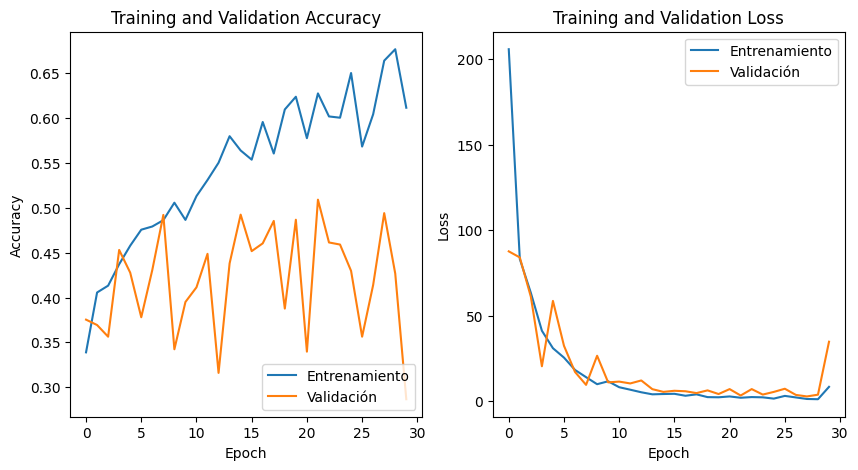

In [57]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_dense.history['accuracy']
val_acc = history_dense.history['val_accuracy']

loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Si bien se podría haber seguido entrenando el modelo con más época (basados en el accuracy de entrenamiento), no se observa ninguna mejora en el tiempo con la accuracy de validación. Dejarlo más épocas únicamente llevaría el modelo a un sobre entrenamiento.

Generamos finalmente una matriz de confusión para analizar las predicciones.

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


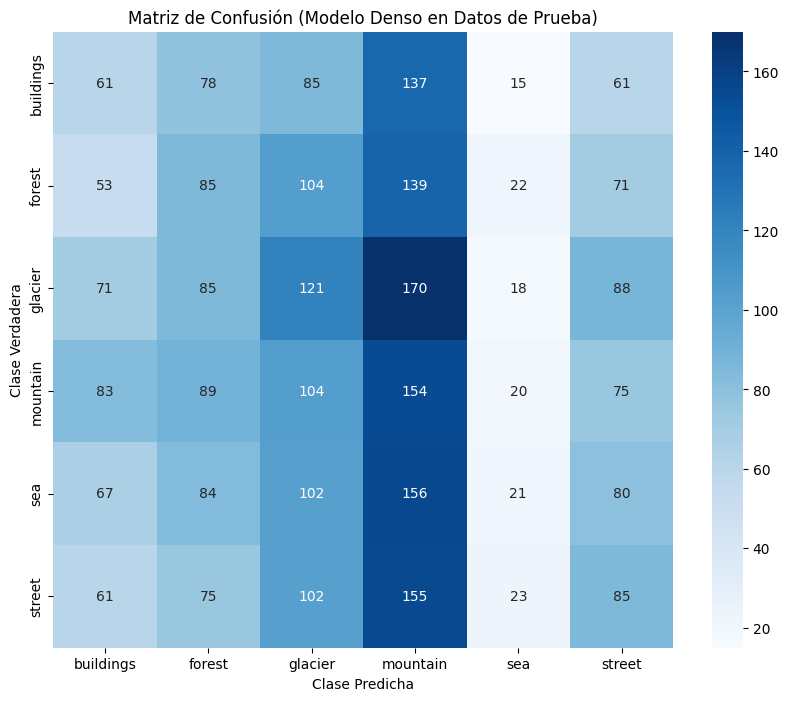


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.15      0.14      0.15       437
      forest       0.17      0.18      0.18       474
     glacier       0.20      0.22      0.21       553
    mountain       0.17      0.29      0.21       525
         sea       0.18      0.04      0.07       510
      street       0.18      0.17      0.18       501

    accuracy                           0.18      3000
   macro avg       0.18      0.17      0.16      3000
weighted avg       0.18      0.18      0.17      3000



In [59]:
# Hacer predicciones en el conjunto de prueba
y_pred_probs = model_dense.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión (Modelo Denso en Datos de Prueba)')
plt.show()

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

El modelo no tiene ninguna buena métrica para ninguna de clases, por lo tanto, es muy poco confiable.

Pruebas con datos para predicciones.

In [58]:
# Carga del mejor modelo
model_dense = load_model(checkpoint_filepath_dense)

# Obtener un batch del val_ds (32 imgs por batch)
for images, labels in pred_ds.take(1):
  sample_images = images[:20]
  break

# Hacer predicciones
predictions = model_dense.predict(sample_images)

# Crear subplots 4x5
fig, axes = plt.subplots(4, 5, figsize=(18, 12))

for idx, ax in enumerate(axes.flat):
  img = sample_images[idx].numpy().astype("uint8")
  pred_class = class_names[np.argmax(predictions[idx])]
  confidence = np.max(predictions[idx]) * 100

  ax.imshow(img)
  ax.set_title(f"Pred: {pred_class}\nConf: {confidence:.1f}%", fontsize = 9)
  ax.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Tras un rápido análisis visual, se puede decir que el modelo no predice de forma satisfactoria, por más confianza que tenga en sus predicciones. El modelo con capas densas no tiene la complejidad suficiente para reconocer estas imágenes.

### Modelo con capas convolucionales y densas

Definimos el modelo usando TensorFlow.

In [60]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)   # Tensorflow se da cuenta que es una capa de aumentación y la usa solo en  el fit
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)

    x = Dense(128)(x)
    x = Dense(64)(x)

    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i],outputs=[x])

Construimos el modelo.

In [61]:
model_conv = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_conv.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Resumen del modelo.

In [62]:
model_conv.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 146, 146, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 33, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,300,518 (16.41 MB)

 Trainable params: 4,300,518 (16.41 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del modelo.

In [63]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=5, verbose=0, mode="min")
# valida el val_loss, histéresis de 0.0, espera 10 ciclos, no imprime nada, busca minimizar

checkpoint_filepath_conv = "/content/models/checkpoint_model_conv.keras"
checkpoint_acc = ModelCheckpoint(
    checkpoint_filepath_conv,
    save_best_only = True,
    monitor = "val_accuracy",
    initial_value_threshold = 0.7,
    mode = "max"
)
# nombre de los checkpoints, guarda cada vez que mejora, monitorea el val_accuracy, guarda modelos a partir de un accuracy del 70%, busca maximizar

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=5, verbose=1, min_delta=1e-6, mode="min", cooldown=0, min_lr=1e-8
) # reduce el learning rate cuando se acerca
# monitorea el loss, lo va reduciendo a un 50%, espera 20 ciclos, imprime un poco, histéresis de 10^-4, busca minimizar

# Número de épocas de entrenamiento
EPOCHS = 50
# Entrena el modelo
history_conv = model_conv.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc]#, reduce_lr, early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2026']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


220/220 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.4335 - loss: 1.4604 - val_accuracy: 0.6330 - val_loss: 0.9661
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.6464 - loss: 0.9226 - val_accuracy: 0.7063 - val_loss: 0.7688
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.7076 - loss: 0.7825 - val_accuracy: 0.7630 - val_loss: 0.6282
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.7465 - loss: 0.6886 - val_accuracy: 0.7887 - val_loss: 0.5835
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.7630 - loss: 0.6319 - val_accuracy: 0.7863 - val_loss: 0.5836
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.7696 - loss: 0.6193 - val_accuracy: 0.7973 - val_loss: 0.5783
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.7715 - loss: 0.6065 - val_accuracy: 0.8233 - val_loss: 0.5180
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.7915 - loss: 0.5685 - val_accurac

Visualizamos resultados de entrenamiento.

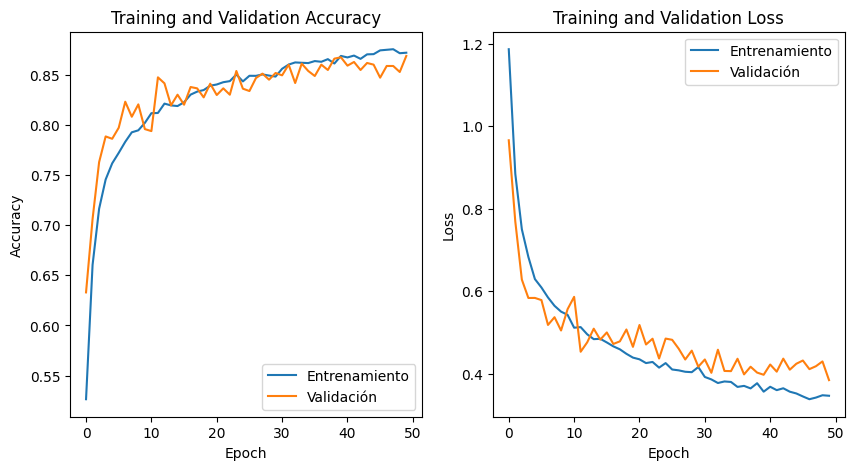

In [64]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_conv.history['accuracy']
val_acc = history_conv.history['val_accuracy']

loss = history_conv.history['loss']
val_loss = history_conv.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Tras 50 épocas, se observa que el modelo convergió bien a un accuracy de valor alto, tanto para entrenamiento como para validación.

Generamos finalmente una matriz de confusión para analizar las predicciones.

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


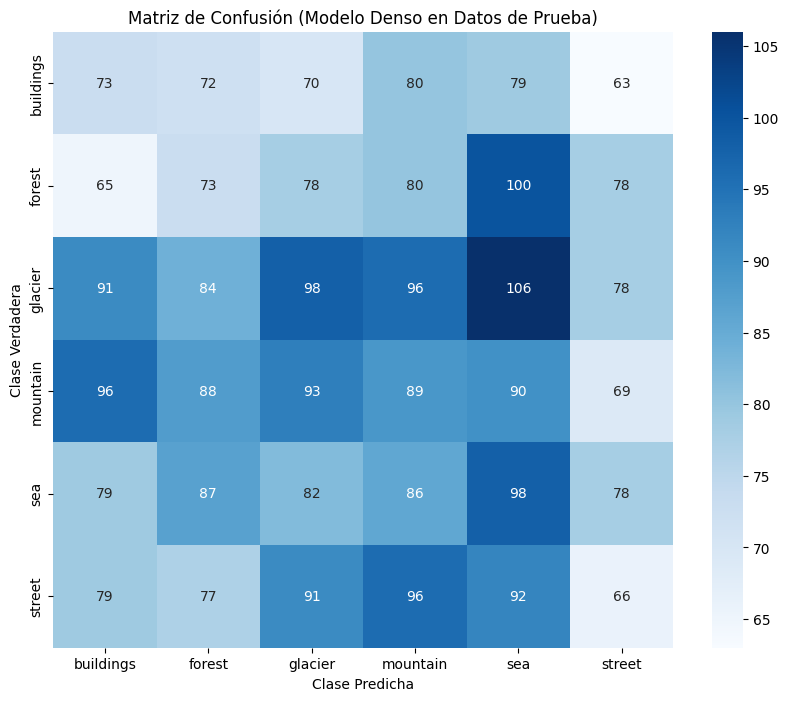


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.15      0.17      0.16       437
      forest       0.15      0.15      0.15       474
     glacier       0.19      0.18      0.18       553
    mountain       0.17      0.17      0.17       525
         sea       0.17      0.19      0.18       510
      street       0.15      0.13      0.14       501

    accuracy                           0.17      3000
   macro avg       0.16      0.17      0.16      3000
weighted avg       0.17      0.17      0.17      3000



In [67]:
# Hacer predicciones en el conjunto de prueba
y_pred_probs = model_conv.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión (Modelo Denso en Datos de Prueba)')
plt.show()

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

A pesar de sus buenas métricas, el modelo sigue confundiendo las etiquetas para las fotos en gran medida.

Pruebas con datos para predicciones.

In [65]:
# Carga del mejor modelo
model_conv = load_model(checkpoint_filepath_conv)

# Obtener un batch del val_ds (32 imgs por batch)
for images, labels in pred_ds.take(1):
  sample_images = images[:20]
  break

# Hacer predicciones
predictions = model_conv.predict(sample_images)

# Crear subplots 4x5
fig, axes = plt.subplots(4, 5, figsize=(18, 12))

for idx, ax in enumerate(axes.flat):
  img = sample_images[idx].numpy().astype("uint8")
  pred_class = class_names[np.argmax(predictions[idx])]
  confidence = np.max(predictions[idx]) * 100

  ax.imshow(img)
  ax.set_title(f"Pred: {pred_class}\nConf: {confidence:.1f}%", fontsize = 9)
  ax.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

No se observan errores groseros y en los casos donde predijo erróneamente, el nivel de confianza es bajo.

### Modelo con bloques residuales identidad

Se utiliza la siguiente arquitectura de bloque residual

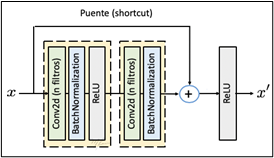

Definimos la arquitectura del bloque residual.

In [68]:
def residual_block(x, filters, stride=1):
  shortcut = x

  # Primera capa convolucional
  x = Conv2D(filters=filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Segunda capa convolucional
  x = Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same')(x)
  x = BatchNormalization()(x)

  # Proyección si cambian las dimensiones
  if shortcut.shape[-1] != filters or stride != 1:
      shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
      shortcut = BatchNormalization()(shortcut)

  # Suma (salida)
  output = Add()([x, shortcut])

  return output

Definimos una función para construir el modelo.
Usamos una arquitectura basada en la siguiente, en donde se aplica una capa convolucional antes de implementar bloques residuales.

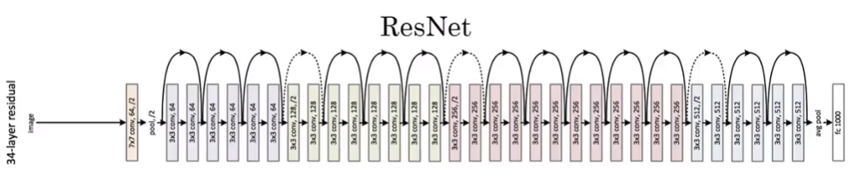

In [69]:
def build_resnet_model(input_shape, num_classes):
  i = Input(shape=input_shape)

  x = Rescaling(1./255)(i)
  x = RandomFlip("horizontal")(x)
  x = RandomFlip("vertical")(x)
  x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
  x = RandomContrast(0.2)(x)

  # Capa convolucional inicial
  x = Conv2D(16, (3,3), padding='same')(x)
  # x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Bloques residuales
  x = residual_block(x, 32)
  x = residual_block(x, 64)
  x = residual_block(x, 128)

  x = GlobalAveragePooling2D()(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(inputs=[i],outputs=[x])

Construimos el modelo.

In [70]:
model_resnet = build_resnet_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_resnet.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Resumen del modelo.

In [71]:
model_resnet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 150, 150,  │          0 │ input_layer_11[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_2       │ (None, 150, 150,  │          0 │ rescaling_9[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_3       │ (None, 150, 150,  │          0 │ random_flip_2[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 150, 150,  │          0 │ random_flip_3[0]… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_1   │ (None, 150, 150,  │          0 │ random_translati… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 150, 150,  │        448 │ random_contrast_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 150, 150,  │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 75, 75,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 75, 75,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 75, 75,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 75, 75,    │      9,248 │ activation_6[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 75, 75,    │        544 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 75, 75,    │          0 │ batch_normalizat

 Total params: 313,510 (1.20 MB)

 Trainable params: 312,166 (1.19 MB)

 Non-trainable params: 1,344 (5.25 KB)

Entrenamiento del modelo.

In [72]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=5, verbose=0, mode="min")
# valida el val_loss, histéresis de 0.0, espera 10 ciclos, no imprime nada, busca minimizar

checkpoint_filepath_resnet = "/content/models/checkpoint_model_resnet.keras"
checkpoint_acc = ModelCheckpoint(
    checkpoint_filepath_resnet,
    save_best_only = True,
    monitor = "val_accuracy",
    initial_value_threshold = 0.7,
    mode = "max"
)
# nombre de los checkpoints, guarda cada vez que mejora, monitorea el val_accuracy, guarda modelos a partir de un accuracy del 70%, busca maximizar

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=5, verbose=1, min_delta=1e-6, mode="min", cooldown=0, min_lr=1e-8
) # reduce el learning rate cuando se acerca
# monitorea el loss, lo va reduciendo a un 50%, espera 20 ciclos, imprime un poco, histéresis de 10^-4, busca minimizar

# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc]#, reduce_lr, early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2093']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


220/220 ━━━━━━━━━━━━━━━━━━━━ 93s 371ms/step - accuracy: 0.5292 - loss: 1.2196 - val_accuracy: 0.3977 - val_loss: 1.8184
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 362ms/step - accuracy: 0.6633 - loss: 0.8780 - val_accuracy: 0.4760 - val_loss: 1.8191
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 354ms/step - accuracy: 0.7018 - loss: 0.7837 - val_accuracy: 0.5283 - val_loss: 1.2454
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 356ms/step - accuracy: 0.7267 - loss: 0.7354 - val_accuracy: 0.6800 - val_loss: 0.8361
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 78s 355ms/step - accuracy: 0.7464 - loss: 0.6780 - val_accuracy: 0.7307 - val_loss: 0.7170
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 82s 355ms/step - accuracy: 0.7582 - loss: 0.6585 - val_accuracy: 0.7250 - val_loss: 0.7004
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 78s 356ms/step - accuracy: 0.7693 - loss: 0.6351 - val_accuracy: 0.7677 - val_loss: 0.6111
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 80s 362ms/step - accuracy: 0.7831 - loss: 0.6051 - val

Visualizamos resultados de entrenamiento.

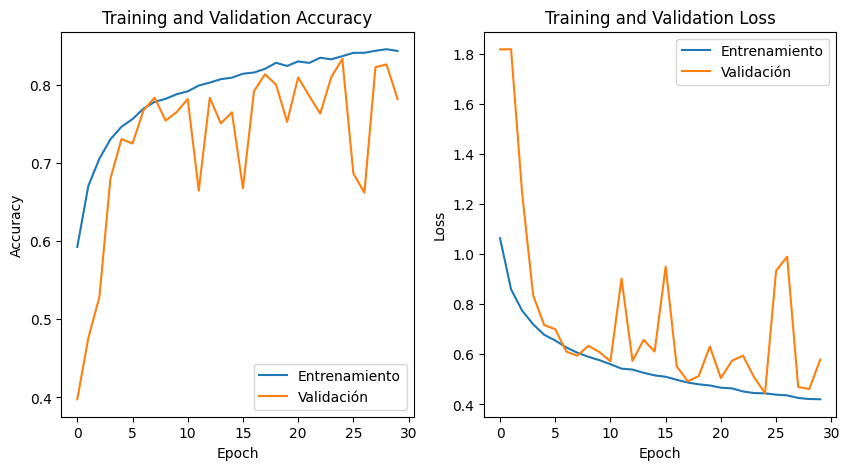

In [73]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']

loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Si bien se obtienen buenas métricas de entrenamiento, las métricas de validación no presentan evoluciones estables. El modelo está pensando para resolver el problema de los gradientes descendientes, algo que no puede ocurrir en la magnitud de lo que se está ensayando aquí. Por lo tanto, no es la mejor opción.

Generamos finalmente una matriz de confusión para analizar las predicciones.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2093']
Received: inputs=Tensor(shape=(64, 150, 150, 3))
  warnings.warn(msg)


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


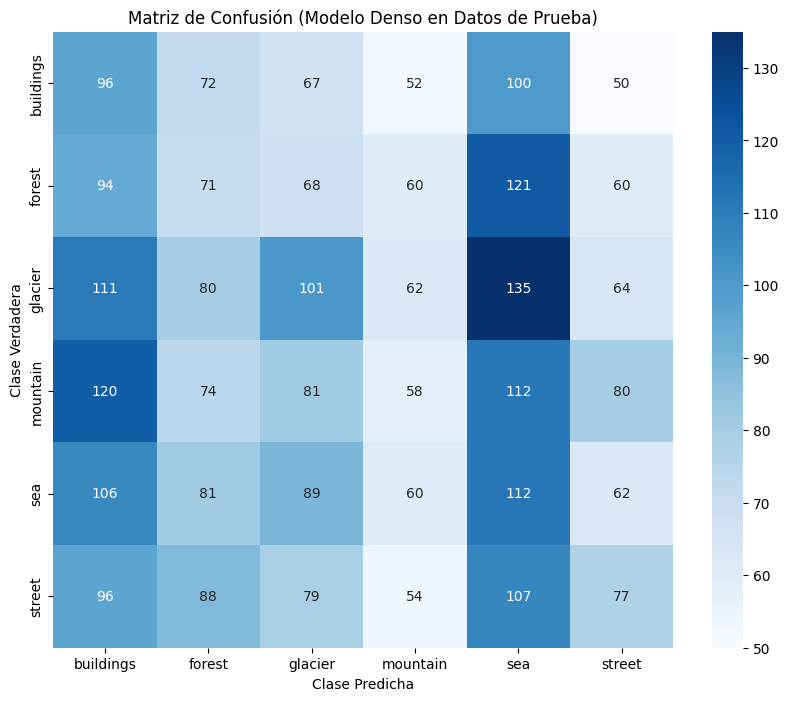


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.15      0.22      0.18       437
      forest       0.15      0.15      0.15       474
     glacier       0.21      0.18      0.19       553
    mountain       0.17      0.11      0.13       525
         sea       0.16      0.22      0.19       510
      street       0.20      0.15      0.17       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.17      3000
weighted avg       0.17      0.17      0.17      3000



In [74]:
# Hacer predicciones en el conjunto de prueba
y_pred_probs = model_resnet.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión (Modelo Denso en Datos de Prueba)')
plt.show()

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

Nuevamente, se observan muchas confusiones.

Pruebas con datos para predicciones.

In [75]:
# Carga del mejor modelo
# model_resnet = load_model(checkpoint_filepath_resnet)

# Obtener un batch del val_ds (32 imgs por batch)
for images, labels in pred_ds.take(1):
  sample_images = images[:20]
  break

# Hacer predicciones
predictions = model_resnet.predict(sample_images)

# Crear subplots 4x5
fig, axes = plt.subplots(4, 5, figsize=(18, 12))

for idx, ax in enumerate(axes.flat):
  img = sample_images[idx].numpy().astype("uint8")
  pred_class = class_names[np.argmax(predictions[idx])]
  confidence = np.max(predictions[idx]) * 100

  ax.imshow(img)
  ax.set_title(f"Pred: {pred_class}\nConf: {confidence:.1f}%", fontsize = 9)
  ax.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Se ven algunas predicciones érroneas, pero en términos generales, el modelo hace buenas aproximaciones.

### Modelo con Transfer Learning - EfficientNetB0

Cargamos el dataset y ajustamos el tamaño de las imágenes. Se recomienda utilizar la misma resolución de entrada que se utilizó para entrenar al modelo backbone.

In [76]:
# Directorio de los datos
DATA_DIRECTORY_TRAIN = Path("/content/seg_train/seg_train")
DATA_DIRECTORY_TEST = Path("/content/seg_test/seg_test")
DATA_DIRECTORY_PRED = Path("/content/seg_pred")
# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
# 224x224 para EfficientNetB0, MobileNet
# 299x299 para InceptionV3
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Carga los datos de entrenamiento, prueba y predicción
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TRAIN,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TEST,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

pred_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_PRED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


Mostramos los nombres de las clases

In [77]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Reducimos el tamaño del dataset para emular un escenario real donde no tenemos muchos datos.

In [78]:
# train_ds = train_ds.take(2000)
# test_ds = test_ds.take(500)

Definimos la arquitectura de la red

In [79]:
def build_transfer_model(input_shape, num_classes):
  backbone = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                              include_top=False,
                                              weights='imagenet') # Utilizamos los pesos del entrenamiento del modelo EfficientNet con el dataset "ImageNet"
  backbone.trainable = False

  i = Input(shape=input_shape)
  x = backbone(i, training=False)
  x = GlobalMaxPooling2D()(x)

  # x = MaxPooling2D((2, 2))(x)
  # x = Flatten()(x)
  # x = Dropout(0.3)(x)
  # x = Dense(128, activation='relu')(x)

  x = Dense(64, activation='relu')(x)

  x = Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(inputs=[i],outputs=[x])

Construimos el modelo.

In [80]:
model_transfer = build_transfer_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_transfer.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Resumen del modelo.

In [81]:
model_transfer.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,945 (15.76 MB)

 Trainable params: 82,374 (321.77 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Entrenamiento del modelo.

In [82]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=5, verbose=0, mode="min")
# valida el val_loss, histéresis de 0.0, espera 10 ciclos, no imprime nada, busca minimizar

checkpoint_filepath_transfer = "/content/models/checkpoint_model_transfer.keras"
checkpoint_acc = ModelCheckpoint(
    checkpoint_filepath_transfer,
    save_best_only = True,
    monitor = "val_accuracy",
    initial_value_threshold = 0.7,
    mode = "max"
)
# nombre de los checkpoints, guarda cada vez que mejora, monitorea el val_accuracy, guarda modelos a partir de un accuracy del 70%, busca maximizar

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=5, verbose=1, min_delta=1e-6, mode="min", cooldown=0, min_lr=1e-8
) # reduce el learning rate cuando se acerca
# monitorea el loss, lo va reduciendo a un 50%, espera 20 ciclos, imprime un poco, histéresis de 10^-4, busca minimizar

# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_transfer = model_transfer.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc]#, reduce_lr, early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2367']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


439/439 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.7673 - loss: 0.7786 - val_accuracy: 0.8883 - val_loss: 0.3638
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - accuracy: 0.8970 - loss: 0.2859 - val_accuracy: 0.8840 - val_loss: 0.3244
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.9155 - loss: 0.2273 - val_accuracy: 0.9020 - val_loss: 0.2698
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.9253 - loss: 0.2019 - val_accuracy: 0.9057 - val_loss: 0.2606
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9374 - loss: 0.1715 - val_accuracy: 0.9043 - val_loss: 0.2762
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.9363 - loss: 0.1646 - val_accuracy: 0.9023 - val_loss: 0.2707
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.9424 - loss: 0.1576 - val_accuracy: 0.8967 - val_loss: 0.3214
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9476 - loss: 0.1370 - val_accura

Visualizamos resultados de entrenamiento.

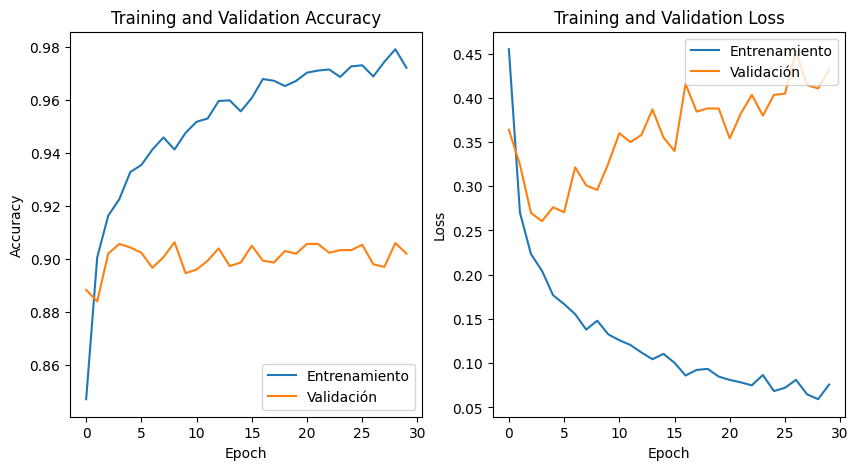

In [83]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Si bien el accuracy de entrenamiento sigue mostrando una tendencia ascendente al momento de la última época, de continuarlo, solo se continuaría acrecentando el sobre ajuste, ya que el accuracy de validación se mantiene constante. Es mejor cortar el entrenamiento del modelo en bajas épocas para evitar este sobre entrenamiento.

Generamos finalmente una matriz de confusión para analizar las predicciones.

94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step


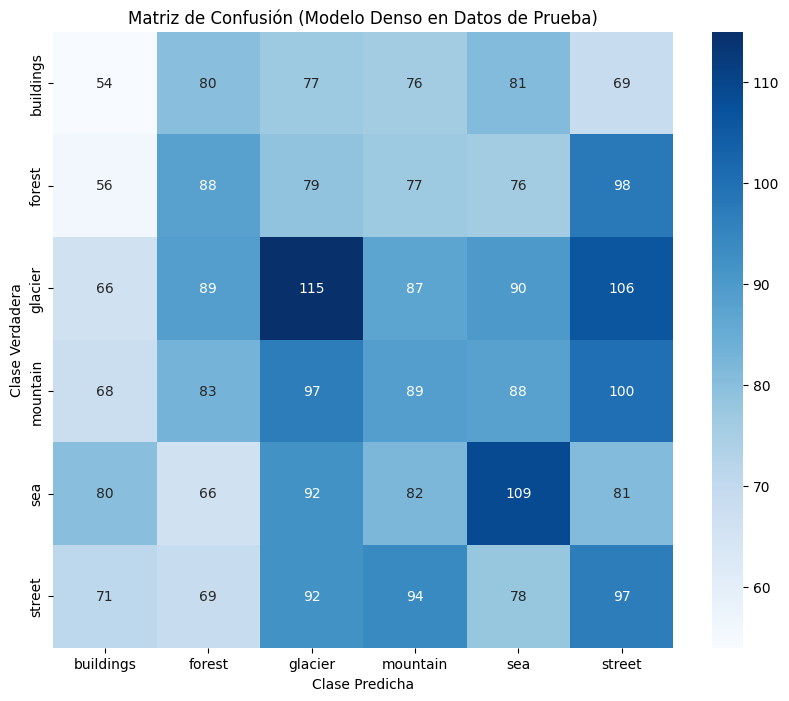


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.14      0.12      0.13       437
      forest       0.19      0.19      0.19       474
     glacier       0.21      0.21      0.21       553
    mountain       0.18      0.17      0.17       525
         sea       0.21      0.21      0.21       510
      street       0.18      0.19      0.18       501

    accuracy                           0.18      3000
   macro avg       0.18      0.18      0.18      3000
weighted avg       0.18      0.18      0.18      3000



In [87]:
# Hacer predicciones en el conjunto de prueba
y_pred_probs = model_transfer.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión (Modelo Denso en Datos de Prueba)')
plt.show()

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

Siguen existiendo muchas predicciones erradas a pesar del alto accuracy.

Pruebas con datos para predicciones.

In [85]:
# Carga del mejor modelo
model_transfer = load_model(checkpoint_filepath_transfer)

# Obtener un batch del val_ds (32 imgs por batch)
for images, labels in pred_ds.take(1):
  sample_images = images[:20]
  break

# Hacer predicciones
predictions = model_transfer.predict(sample_images)

# Crear subplots 4x5
fig, axes = plt.subplots(4, 5, figsize=(18, 12))

for idx, ax in enumerate(axes.flat):
  img = sample_images[idx].numpy().astype("uint8")
  pred_class = class_names[np.argmax(predictions[idx])]
  confidence = np.max(predictions[idx]) * 100

  ax.imshow(img)
  ax.set_title(f"Pred: {pred_class}\nConf: {confidence:.1f}%", fontsize = 9)
  ax.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

A pesar el posible sobre entrenamiento, el rendimiento del modelo es muy satisfactorio, logrando un buen nivel de precisión.

### Modelo con Transfer Learning - MobileNet

Cargamos el dataset y ajustamos el tamaño de las imágenes. Se recomienda utilizar la misma resolución de entrada que se utilizó para entrenar al modelo backbone.

In [88]:
# Directorio de los datos
DATA_DIRECTORY_TRAIN = Path("/content/seg_train/seg_train")
DATA_DIRECTORY_TEST = Path("/content/seg_test/seg_test")
DATA_DIRECTORY_PRED = Path("/content/seg_pred")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
# 224x224 para EfficientNetB0, MobileNet
# 299x299 para InceptionV3
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Carga los datos de entrenamiento, prueba y predicción
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TRAIN,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TEST,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

pred_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_PRED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files belonging to 1 classes.


Mostramos los nombres de las clases

In [89]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Reducimos el tamaño del dataset para emular un escenario real donde no tenemos muchos datos.

In [90]:
# train_ds = train_ds.take(2000)
# test_ds = test_ds.take(500)

Preprocesamos los datos, para adaptaros al formato requerido por MobileNet.

In [91]:
# Esto no estoy seguro de si es necesario hacerlo porque ya lo hago dentro del modelo

# Aplicar el preprocesamiento de MobileNet a los datasets

# train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
# test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))
# pred_ds = pred_ds.map(lambda x, y: (preprocess_input(x), y))

Definimos la arquitectura de la red.

In [92]:
def build_transfer_model_mn(input_shape, num_classes):
  backbone = tf.keras.applications.MobileNet(input_shape=input_shape,
                                              include_top=False,
                                              weights='imagenet') # Utilizo los pesos del entrenamiento del modelo MobileNet con el dataset "ImageNet"
  backbone.trainable = False

  i = Input(shape=input_shape)
  x = preprocess_input(i)
  # x = backbone(i, training=False)
  x = backbone(x, training=False)
  x = GlobalMaxPooling2D()(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)

  return tf.keras.Model(inputs=[i],outputs=[x])

Construimos el modelo.

In [93]:
model_transfer_mn = build_transfer_model_mn((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_transfer_mn.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Resumen del modelo.

In [94]:
model_transfer_mn.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_4          │ (None, 1024)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,294,854 (12.57 MB)

 Trainable params: 65,990 (257.77 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Entrenamiento del modelo.

In [95]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=5, verbose=0, mode="min")
# valida el val_loss, histéresis de 0.0, espera 10 ciclos, no imprime nada, busca minimizar

checkpoint_filepath_transfer_mn = "/content/models/checkpoint_model_transfer_mn.keras"
checkpoint_acc = ModelCheckpoint(
    checkpoint_filepath_transfer_mn,
    save_best_only = True,
    monitor = "val_accuracy",
    initial_value_threshold = 0.7,
    mode = "max"
)
# nombre de los checkpoints, guarda cada vez que mejora, monitorea el val_accuracy, guarda modelos a partir de un accuracy del 70%, busca maximizar

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=5, verbose=1, min_delta=1e-6, mode="min", cooldown=0, min_lr=1e-8
) # reduce el learning rate cuando se acerca
# monitorea el loss, lo va reduciendo a un 50%, espera 20 ciclos, imprime un poco, histéresis de 10^-4, busca minimizar

# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history_transfer_mn = model_transfer_mn.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_acc]#, reduce_lr, early_stopping]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2965']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


220/220 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - accuracy: 0.6785 - loss: 1.2759 - val_accuracy: 0.8673 - val_loss: 0.3523
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.8829 - loss: 0.3356 - val_accuracy: 0.8843 - val_loss: 0.3137
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9049 - loss: 0.2712 - val_accuracy: 0.9030 - val_loss: 0.2670
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9175 - loss: 0.2382 - val_accuracy: 0.8687 - val_loss: 0.3595
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9226 - loss: 0.2135 - val_accuracy: 0.8990 - val_loss: 0.2781
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9234 - loss: 0.2010 - val_accuracy: 0.9060 - val_loss: 0.2617
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.9329 - loss: 0.1776 - val_accuracy: 0.9070 - val_loss: 0.2639
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9360 - loss: 0.1713 - val_accura

Visualizamos resultados de entrenamiento.

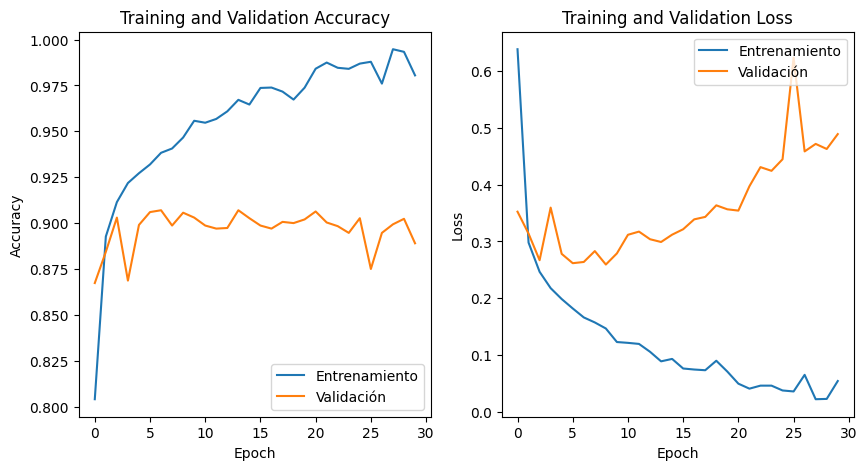

In [96]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_transfer_mn.history['accuracy']
val_acc = history_transfer_mn.history['val_accuracy']

loss = history_transfer_mn.history['loss']
val_loss = history_transfer_mn.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Al igual que en el caso de EfficientNet, se observa que el accuracy de entrenamiento crece mientras que el de validación no se mueve. Si bien se podría haber seguido entrenando, nuevamente, se acrecentaría el sobre entrenamiento.

Generamos finalmente una matriz de confusión para analizar las predicciones.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2965']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step


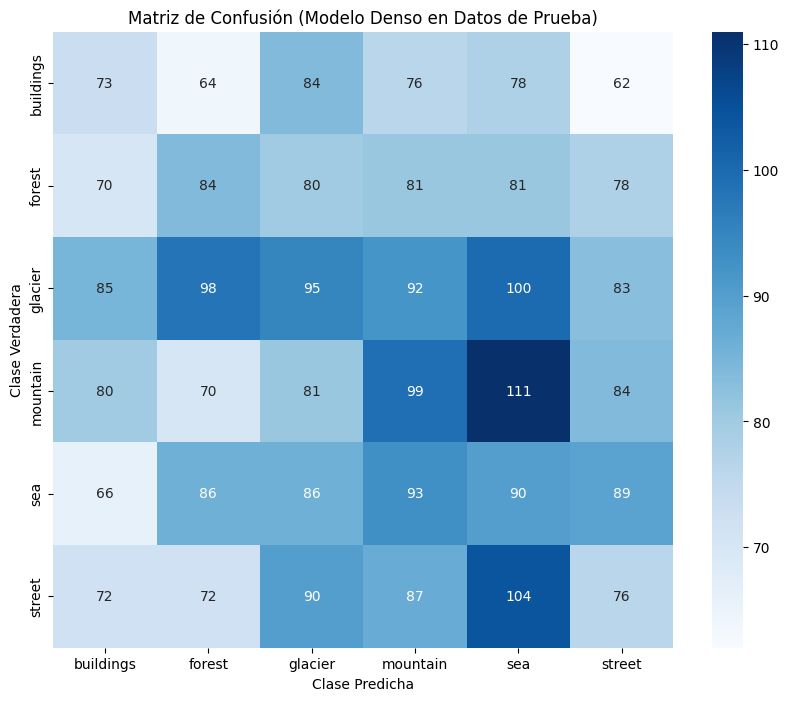


Reporte de Clasificación:
              precision    recall  f1-score   support

   buildings       0.16      0.17      0.17       437
      forest       0.18      0.18      0.18       474
     glacier       0.18      0.17      0.18       553
    mountain       0.19      0.19      0.19       525
         sea       0.16      0.18      0.17       510
      street       0.16      0.15      0.16       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.17      3000
weighted avg       0.17      0.17      0.17      3000



In [97]:
# Hacer predicciones en el conjunto de prueba
y_pred_probs = model_transfer_mn.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.title('Matriz de Confusión (Modelo Denso en Datos de Prueba)')
plt.show()

# Mostrar el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

Existe una tendencia a predecir correctamente, pero siguen habiendo muchas clasificaciones erróneas.

Pruebas con datos para predicciones.

In [98]:
# Carga del mejor modelo
model_transfer_mn = load_model(checkpoint_filepath_transfer_mn)

# Obtener un batch del val_ds (32 imgs por batch)
for images, labels in pred_ds.take(1):
  sample_images = images[:20]
  break

# Hacer predicciones
predictions = model_transfer_mn.predict(sample_images)

# Crear subplots 4x5
fig, axes = plt.subplots(4, 5, figsize=(18, 12))

for idx, ax in enumerate(axes.flat):
  img = sample_images[idx].numpy().astype("uint8")
  pred_class = class_names[np.argmax(predictions[idx])]
  confidence = np.max(predictions[idx]) * 100

  ax.imshow(img)
  ax.set_title(f"Pred: {pred_class}\nConf: {confidence:.1f}%", fontsize = 9)
  ax.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Nuevamente, se ve un desempeño muy satisfactorio.

### Comparativa de modelos

Graficamos las evoluciones de accuracy y loss de cada modelo.

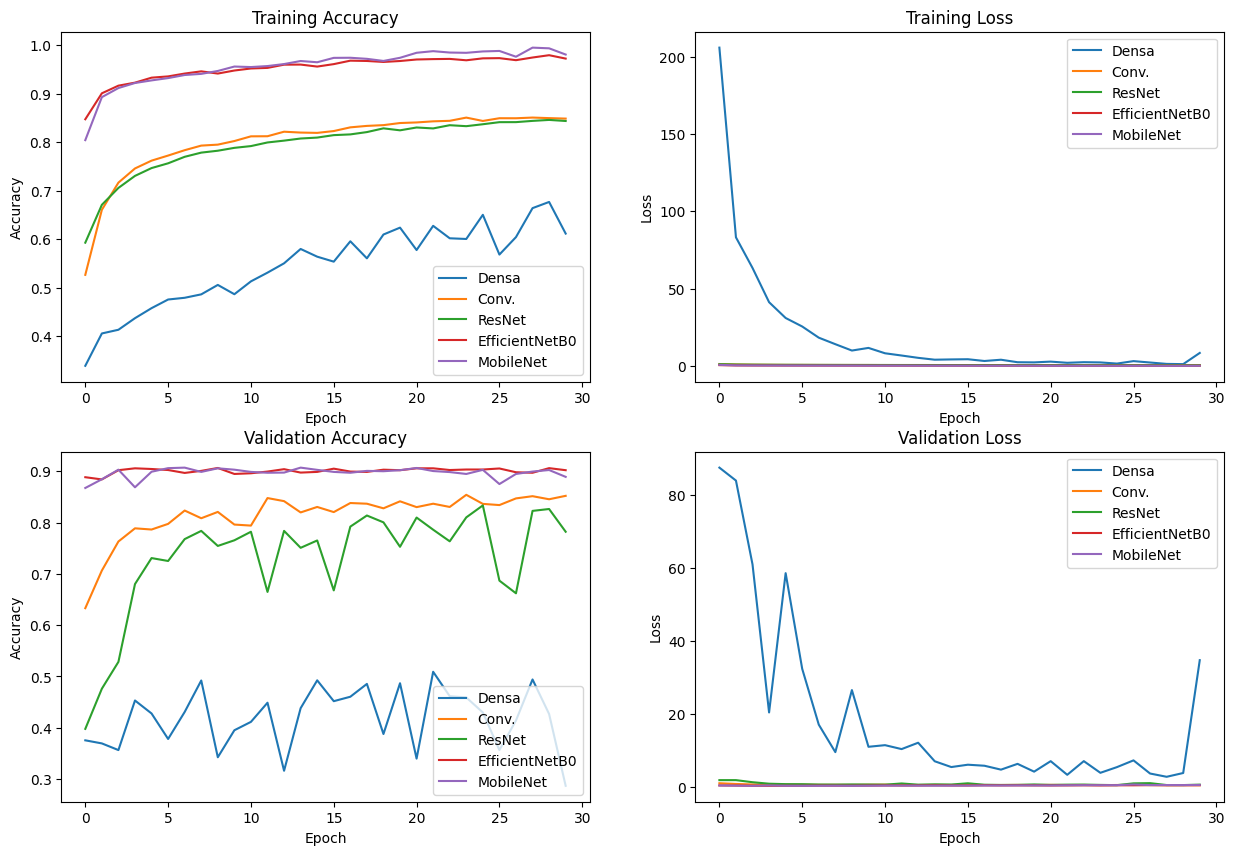

In [99]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc_dense = history_dense.history['accuracy']
val_acc_dense = history_dense.history['val_accuracy']

loss_dense = history_dense.history['loss']
val_loss_dense = history_dense.history['val_loss']

acc_conv = history_conv.history['accuracy']
val_acc_conv = history_conv.history['val_accuracy']

loss_conv = history_conv.history['loss']
val_loss_conv = history_conv.history['val_loss']

acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']

loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']

acc_transfer = history_transfer.history['accuracy']
val_acc_transfer = history_transfer.history['val_accuracy']

loss_transfer = history_transfer.history['loss']
val_loss_transfer = history_transfer.history['val_loss']

acc_transfer_mn = history_transfer_mn.history['accuracy']
val_acc_transfer_mn = history_transfer_mn.history['val_accuracy']

loss_transfer_mn = history_transfer_mn.history['loss']
val_loss_transfer_mn = history_transfer_mn.history['val_loss']

# Obtener la longitud mínima de las listas de precisión y pérdida
min_len = min(len(acc_dense), len(acc_conv), len(acc_resnet), len(acc_transfer), len(acc_transfer_mn))

# Ajustar epochs_range para que coincida con la longitud mínima
epochs_range = range(min_len)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc_dense[:min_len], label='Densa')
plt.plot(epochs_range, acc_conv[:min_len], label='Conv.')
plt.plot(epochs_range, acc_resnet[:min_len], label='ResNet')
plt.plot(epochs_range, acc_transfer[:min_len], label='EfficientNetB0')
plt.plot(epochs_range, acc_transfer_mn[:min_len], label='MobileNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss_dense[:min_len], label='Densa')
plt.plot(epochs_range, loss_conv[:min_len], label='Conv.')
plt.plot(epochs_range, loss_resnet[:min_len], label='ResNet')
plt.plot(epochs_range, loss_transfer[:min_len], label='EfficientNetB0')
plt.plot(epochs_range, loss_transfer_mn[:min_len], label='MobileNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, val_acc_dense[:min_len], label='Densa')
plt.plot(epochs_range, val_acc_conv[:min_len], label='Conv.')
plt.plot(epochs_range, val_acc_resnet[:min_len], label='ResNet')
plt.plot(epochs_range, val_acc_transfer[:min_len], label='EfficientNetB0')
plt.plot(epochs_range, val_acc_transfer_mn[:min_len], label='MobileNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, val_loss_dense[:min_len], label='Densa')
plt.plot(epochs_range, val_loss_conv[:min_len], label='Conv.')
plt.plot(epochs_range, val_loss_resnet[:min_len], label='ResNet')
plt.plot(epochs_range, val_loss_transfer[:min_len], label='EfficientNetB0')
plt.plot(epochs_range, val_loss_transfer_mn[:min_len], label='MobileNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')

plt.show()

Hay una diferencia notoria entre el desempeño de los modelos con backbone frente al resto de los modelos ensayados. Esto se debe a que fueron entrenados con una cantidad inmensa de imágenes, logrando adaptarse a otras situaciones.

Como es de esperar, el modelo con capas densas presenta el peor desempeño, mientras que los modelos con capas convolucionales y ResNet poseen un desempeño parecido entre sí y aceptable.